In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<style>
.rendered_html td {
    font-size: xx-large;
    text-align: left; !important
}
.rendered_html th {
    font-size: xx-large;
    text-align: left; !important
}
</style>

In [2]:
%%capture
import sys
sys.path.append("..")
import statnlpbook.util as util
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\bar}{\,|\,}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

In [3]:
%load_ext tikzmagic

# Machine Translation

## Schedule

+ History: machine translation (5 min.)

+ Background: neural MT (10 min.)

+ Example: beam search (10 min.)

+ Math: BLEU (5 min.)

+ Math: attention (10 min.)

+ Break (10 min.)

+ Math: self-attention (10 min.)

+ Examples: self-attention (5 min.)

+ Math: transformers (5 min.)

+ Background: BERT (10 min.)

+ Background: mBERT (10 min.)

+ Background: GPT-$n$ and others (5 min.)

## Languages are hard (even for humans)!

<center style="padding-top:3em;">
  <img src="mt_figures/whatever.jpg" />
    
  <span style="font-size:50%;">(Source: <a href="https://www.flickr.com/photos/98991392@N00/8729849093/sizes/z/in/pool-47169589@N00/">Flickr</a>)</span>
</center>

[随便](https://translate.google.com/#view=home&op=translate&sl=zh-CN&tl=en&text=%E9%9A%8F%E4%BE%BF)

## Automatic machine translation is hard!

<center style="padding-top:3em;">
<img src="../chapters/mt_figures/avocado.png" width="100%"/>
</center>

## How to implement?

<center>
   <img src="mt_figures/brief_history.png" width="100%" />
   
   <span style="font-size:50%;">(Source: <a href="https://www.freecodecamp.org/news/a-history-of-machine-translation-from-the-cold-war-to-deep-learning-f1d335ce8b5/">freeCodeCamp</a>)</span>
</center>

## How to implement?

* Four paradigms:
  * Rule-based machine translation (RBMT)
  * Example-based machine translation (EBMT)
  * Statistical machine translation (SMT)
  * Neural machine translation (NMT)
    &nbsp;

* An informal but entertaining overview: ["A history of machine translation from the Cold War to deep learning"](https://www.freecodecamp.org/news/a-history-of-machine-translation-from-the-cold-war-to-deep-learning-f1d335ce8b5/)

* Details about SMT in [previous slides from this repo](word_mt_slides.ipynb)

## Neural Machine Translation

Sequence-to-sequence model (seq2seq), encoder–decoder architecture

&nbsp;

<center>
    <img src="mt_figures/encdec.svg" width="70%" />
</center>

(Examples are Basque–English)

### We can use RNNs for that!

&nbsp;

<center>
    <img src="mt_figures/encdec_rnn1.svg" width="70%" />
</center>

### Encoder

+ Word embedding layer
+ **Bi-directional LSTM** to best capture contextual information

### Decoder

+ **Uni-directional LSTM** — because we need to *decode* from left to right!
+ Softmax layer on top


### But something's missing (again)...

&nbsp;

<center>
    <img src="mt_figures/encdec_rnn1.svg" width="70%" />
</center>

Output words **depend on each other**!

## The input-feeding approach

&nbsp;

<center>
    <img src="mt_figures/encdec_rnn2.svg" width="70%" />
</center>

### What is happening here exactly?

+ We added an **embedding layer** to the decoder
+ At the first timestep, we use a special **start symbol** (here: `<S>`) as input
+ We **feed the predictions** back into the next timestep:

  1. The softmax layer gives us a probability distribution over words
  2. We pick the most likely one *(greedy decoding)*
  3. We use its embedding as input for the decoder's next timestep

### Training the model

+ Loss function: negative log-likelihood
  - Just as before!  Words ~ Labels
    &nbsp;

+ **Teacher forcing:**  always feed the ground truth into the decoder

*Alternative:*

+ **Scheduled sampling:** with a certain probability, use model predictions instead


### Training the model

+ **Vocabulary size** becomes a problem
  $\rightarrow$ Have to do softmax over *all words in the target language!*
  &nbsp;

+ Solution 1: **restrict the vocabulary**
  - Use only $n$ most frequent words (e.g., $n = 50000$)
  - Replace all less frequent words with `<UNK>` symbol
  &nbsp;

+ Solution 2: **subword tokenization** (see [§13.6.2 in Koehn](https://arxiv.org/pdf/1709.07809.pdf))
  - Byte-pair encoding (BPE)
  - Character-based decoding

### Why do we need to handle decoding?

$\rightarrow$ *We don't know how long the output sequence is going to be!*

+ Special symbol to denote *end of sequence*
+ For example: `</S>`, `<EOS>`, `<END>`, ...

### Greedy decoding

For machine translation:

+ Always pick the **most likely word** (according to the softmax)
+ Continue generating more words **until the `</S>` symbol is predicted**

## Beam search decoding

Recall:

+ Greedy decoding may lead to **search errors** when returned $\y$ is not highest scoring **global** solution

+ With input feeding, future predictions will change based on previous ones

+ Exhaustive search not feasible


Popular solution:

+ **Beam search** as an *approximate search strategy*

### Beam search algorithm (again)

Keep a "beam" of the best $\beta$ previous solutions

1. Choose $\beta$ highest scoring labels for token 1
2. 1. For each of the previous $\beta$ labels: predict probabilities for next label, conditioned on the previous label(s)
   2. **Sum** the log-likelihoods for previous states and next label
   3. **Prune** the beam by only keeping the top $\beta$ paths
3. Repeat until **all items reach** end of sequence

### An example

Beam size $\beta = 3$

| $y_0$ | $y$ | $\log p_\theta(y|\x,\langle S \rangle )$ |
|-|-|-|
| &lt;S&gt; | I | -1.670 |
| &lt;S&gt; | We | -3.266 |
| &lt;S&gt; | He | -3.364 |
| &lt;S&gt; | She | -3.366 |
| &lt;S&gt; | They | -4.920 |
| &lt;S&gt; | ... | ... |


### An example

Beam size $\beta = 3$

| $y_0$ | $y$ | $\log p_\theta(y|\x,\langle S \rangle )$ |
|-|-|-|
| **&lt;S&gt;** | **I** | **-1.670** |
| **&lt;S&gt;** | **We** | **-3.266** |
| **&lt;S&gt;** | **He** | **-3.364** |
| &lt;S&gt; | She | -3.366 |
| &lt;S&gt; | They | -4.920 |
| &lt;S&gt; | ... | ... |

1. Choose $\beta$ highest scoring labels

### An example

Beam size $\beta = 3$

### Our beam

| $y_0,y_1$ | $\log p_\theta(y_0,y_1|\x)$ |
|-|-|
| &lt;S&gt; I | -1.670 |
| &lt;S&gt; We | -3.266 |
| &lt;S&gt; He | -3.364 |


### An example

Beam size $\beta = 3$

| $y_0,y_1$ | $y$ | $\log p_\theta(y|\x,\langle S \rangle \text{ I})$ | | $y_0,y_1$ | $y$ | $\log p_\theta(y|\x,\langle S \rangle \text{ We})$ | | $y_0,y_1$ | $y$ | $\log p_\theta(y|\x,\langle S \rangle \text{ He})$ |
|-|-|-|-|-|-|-|-|-|-|-|
| &lt;S&gt; I | love | -1.141 | | &lt;S&gt; We | love | -1.129 | | &lt;S&gt; He | loves | -2.916 |
| &lt;S&gt; I | like | -1.673 | | &lt;S&gt; We | like | -2.367 | | &lt;S&gt; He | will  | -4.267 |
| &lt;S&gt; I | enjoy | -3.906 | | &lt;S&gt; We | have | -2.904 | | &lt;S&gt; He | likes | -4.619 |
| &lt;S&gt; I | have | -4.366 | | &lt;S&gt; We | enjoy | -4.148 | | &lt;S&gt; He | loved | -5.698 |
| &lt;S&gt; I | ... | ... | | &lt;S&gt; We | ... | ... | | &lt;S&gt; He | ... | ... |

2. A. For each of the previous $\beta$ labels: predict probabilities for next label, conditioned on the previous label(s)

### An example

Beam size $\beta = 3$

| $y_0,y_1$ | $y$ | $\log p_\theta(y|\x,\langle S \rangle \text{ I})-1.670$ | | $y_0,y_1$ | $\y$ | $\log p_\theta(y|\x,\langle S \rangle \text{ We})-3.266$ | | $y_0,y_1$ | $\y$ | $\log p_\theta(y|\x,\langle S \rangle \text{ He})-3.364$ |
|-|-|-|-|-|-|-|-|-|-|-|
| &lt;S&gt; I | love | -2.811 | | &lt;S&gt; We | love | -4.395 | | &lt;S&gt; He | loves | -6.280 |
| &lt;S&gt; I | like | -3.343 | | &lt;S&gt; We | like | -5.633 | | &lt;S&gt; He | will  | -7.631 |
| &lt;S&gt; I | enjoy | -5.576 | | &lt;S&gt; We | have | -6.170 | | &lt;S&gt; He | likes | -7.983 |
| &lt;S&gt; I | have | -6.036 | | &lt;S&gt; We | enjoy | -7.414 | | &lt;S&gt; He | loved | -9.062 |
| &lt;S&gt; I | ... | ... | | &lt;S&gt; We | ... | ... | | &lt;S&gt; He | ... | ... |

2. B. **Sum** the log-likelihoods for previous states and next label

because $\log p_\theta(y_0,y_1,y|\x) = \log p_\theta(y|\x,y_0, y_1) + \log p_\theta(y_0,y_1|\x)$ (Bayes' rule)


### An example

Beam size $\beta = 3$

| $y_0,y_1$ | $y$ | $\log p_\theta(\y|\x)$ | | $y_0$ | $\y$ | $\log p_\theta(\y|\x)$ | | $y_0$ | $\y$ | $\log p_\theta(\y|\x)$ |
|-|-|-|-|-|-|-|-|-|-|-|
| **&lt;S&gt; I** | **love** | **-2.811** | | **&lt;S&gt; We** | **love** | **-4.395** | | &lt;S&gt; He | loves | -6.280 |
| **&lt;S&gt; I** | **like** | **-3.343** | | &lt;S&gt; We | like | -5.633 | | &lt;S&gt; He | will  | -7.631 |
| &lt;S&gt; I | enjoy | -5.576 | | &lt;S&gt; We | have | -6.170 | | &lt;S&gt; He | likes | -7.983 |
| &lt;S&gt; I | have | -6.036 | | &lt;S&gt; We | enjoy | -7.414 | | &lt;S&gt; He | loved | -9.062 |
| &lt;S&gt; I | ... | ... | | &lt;S&gt; We | ... | ... | | &lt;S&gt; He | ... | ... |

2. C. **Prune** the beam by only keeping the top $\beta$ paths


### An example

Beam size $\beta = 3$

### Our beam

| $\y$ | $\log p_\theta(\y|\x)$ |
|-|-|
| &lt;S&gt; I love | -2.811 |
| &lt;S&gt; I like | -3.343 |
| &lt;S&gt; We love | -4.395 |


+ Continue until all hypotheses have generated `</S>`
+ Typically: normalize by length of hypothesis to find final prediction

## Evaluation

We're training the model with *negative log-likelihood*, but that's not the best way to *evaluate* it.

Consider:
    
+ After lunch, he went to the gym.
+ After he had lunch, he went to the gym.
+ He went to the gym after lunch.
+ He went to the gym after lunchtime.

In machine translation, there are often **several acceptable variations!**

## BLEU score

A widely used, but simplistic, metric:

+ Compare the prediction to one or more reference translations.
+ Count the number of matching $n$-grams between them.
  - It is common to consider $1 \le n \le 4$
+ Divide by total number of $n$-grams.

The BLEU score will range between 0 (*no match at all*) and 1.0 (*perfect match*, 100%)

### BLEU score examples

In [2]:
from nltk.translate.bleu_score import sentence_bleu
refs = [["After", "lunch", ",", "he", "went", "to", "the", "gym", "."],
        ["He", "went", "to", "the", "gym", "after", "lunch", "."]]

sentence_bleu(refs, ["After", "lunch", ",", "he", "went", "to", "the", "gym", "."])

1.0

In [4]:
sentence_bleu(refs, ["Turtles", "are", "great", "animals", "."])

6.686350417856737e-232

### BLEU score examples

In [5]:
sentence_bleu(refs, ["After", "he", "had", "lunch", ",", "he", "went", "to", "the", "gym", "."])

0.6989307622784944

In [6]:
sentence_bleu(refs, ["After", "lunch", ",", "he", "went", "to", "the", "pizzeria", "."])

0.7506238537503395

In [7]:
sentence_bleu(refs, ["Before", "lunch", ",", "he", "went", "to", "the", "gym", "."])

0.8633400213704505

+ BLEU is very simplistic
+ Many alternatives have been proposed
+ ...but BLEU still remains the de-facto standard

## More problems with our approach

&nbsp;

<center>
    <img src="mt_figures/encdec_rnn2.svg" width="70%" />
</center>

## More problems with our approach

&nbsp;

<center>
    <img src="mt_figures/encdec_rnn3.svg" width="70%" />
</center>

    "You can't cram the meaning of a whole %&!$ing sentence into a single $&!*ing vector!"

— Ray Mooney

## Idea

+ Traditional (non-neural) MT models often perform **alignment** between sequences

<center style="padding: 1em 0;">
    <img src="mt_figures/align.svg" width="20%" />
</center>

+ Can we learn something similar with our encoder–decoder model?

## Attention mechanism

+ Original motivation: Bahdanau et al. 2014, [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

#### Idea

+ Each encoder timestep gives us a **contextual representation** of the corresponding input token
+ A **weighted combination** of those is a differentiable function
+ Computing such a combination for each decoder timestep can give us a **soft alignment**

<center>
    <img src="mt_figures/encdec_att.svg" width="40%" />
</center>

### What is happening here?

**Attention model** takes as input:

+ Hidden state of the decoder $\mathbf{s}_t^{\textrm{dec}}$
+ All encoder hidden states $(\mathbf{h}_1^{\textrm{enc}}, \ldots, \mathbf{h}_n^{\textrm{enc}})$


**Attention model** produces:

+ An attention vector $\mathbf{\alpha}_t \in \mathbb{R}^n$ (where $n$ is the length of the source sequence)
+ $\mathbf{\alpha}_t$ is computed as a softmax distribution:

$$
\mathbf{\alpha}_{t,j} = \text{softmax}\left(f_{\mathrm{att}}(\mathbf{s}_{t-1}^{\textrm{dec}}, \mathbf{h}_j^{\textrm{enc}})\right)
$$

### How do we compute $f_\mathrm{att}$?

Usually with a very simple feedforward neural network.

For example:

$$
f_{\mathrm{att}}(\mathbf{s}_{t-1}^{\textrm{dec}}, \mathbf{h}_j^{\textrm{enc}}) =
\tanh
\left(
\mathbf{W}^s \mathbf{s}_{t-1}^{\textrm{dec}} +
\mathbf{W}^h \mathbf{h}_j^{\textrm{enc}}
\right)
$$

This is called **additive** attention.

Another alternative:

$$
f_{\mathrm{att}}(\mathbf{s}_{t-1}^{\textrm{dec}}, \mathbf{h}_j^{\textrm{enc}}) =
\frac{\left(\mathbf{s}_{t-1}^{\textrm{dec}}\right)^\intercal
\mathbf{W} \mathbf{h}_j^{\textrm{enc}}}
{\sqrt{d_{\mathbf{h}^{\textrm{enc}}}}}
$$

This is called **scaled dot-product** attention.

(But many alternatives have been proposed!)

### What do we do with $\mathbf{\alpha}_t$?

Computing a **context vector:**

$$
\mathbf{c}_t = \sum_{i=1}^n \mathbf{\alpha}_{t,i} \mathbf{h}_i^\mathrm{enc}
$$

This is the weighted combination of the input representations!


Include this context vector in the calculation of decoder's hidden state:

$$
\mathbf{s}_t^{\textrm{dec}} = f\left(\mathbf{s}_{t-1}^{\textrm{dec}}, \mathbf{y}_{t-1}^\textrm{dec}, \mathbf{c}_t\right)
$$

<center>
    <img src="mt_figures/encdec_att.svg" width="22%" />
</center>

> Intuitively, this implements a mechanism of attention in the decoder.  The decoder **decides parts of the source sentence to pay attention to.**  By letting the decoder have an attention mechanism, we relieve the encoder from the burden of having to encode all information in the source sentence into a fixed-length vector.

<div style="text-align: right;">
    (from <a href="https://arxiv.org/pdf/1409.0473.pdf">Bahdanau et al., 2014</a>)
</div>

We can visualize what this model learns in an

## Attention matrix

&nbsp;

$\rightarrow$ Simply concatenate all $\alpha_t$ for $1 \leq t \leq m$

<center>
    <img src="mt_figures/att_matrix.png" width="40%" />
</center>

<div style="text-align: right;">
    (from <a href="https://arxiv.org/pdf/1409.0473.pdf">Bahdanau et al., 2014</a>)
</div>

### An important caveat

+ The attention mechanism was motivated by the idea of aligning inputs & outputs
+ Attention matrices often correspond to human intuitions about alignment
+ But ***producing a sensible alignment is not a training objective!***

In other words:

+ Do not expect that attention weights will *necessarily* correspond to sensible alignments!

## Summary so far

+ **Encoder–decoder** architecture with (bi-)LSTMs
  - Input feeding
  - Teacher forcing

+ **Beam search** vs. greedy decoding

+ Evaluation with **BLEU**

+ **Attention** mechanism


## Outlook

Competitive machine translation models are *very time-intensive* to train!

+ Example: [Wu et al. (2016)](https://arxiv.org/pdf/1609.08144.pdf) describe Google's NMT system

+ Encoder–decoder with attention & stack of 8 LSTM layers
  (plus some other additions)
  
+ 36 million sentence pairs for English-to-French setting (En→Fr)

Quote:

> On WMT En→Fr, it takes around 6 days to train a basic model using 96 NVIDIA K80 GPUs.


More recent development:

### Transformer models

+ Described in Vaswani et al. (2017) paper famously titled [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
+ Gets rid of RNNs, uses attention calculations everywhere (also called **self-attention**)
+ Used in most current state-of-the-art NMT models

From a [paper recently submitted to ICLR 2020](https://openreview.net/pdf?id=Bkl8YR4YDB):

+ Setting is training NMT on Chinese–English with 50 **billion** sentence pairs

> We use a single transformer model to fit all the training data.  We use 512 Nvidia V100 GPUs with mini-batches of approximately 1M tokens. [...] Upon the submission of this paper, training has lasted for three months, 2 epochs in total, and perplexity on the development set is still dropping.

## Self-attention

Each word attends to all words.

<center>
    <img src="mt_figures/self_att.png" width=25%/>
</center>

<div style="text-align: right;">
    (from <a href="https://arxiv.org/pdf/1706.03762.pdf">Vaswani et al., 2017</a>)
</div>

## Multi-head self-attention

<center>
    <img src="mt_figures/multi_head_self_att.png" width=30%/>
</center>

<div style="text-align: right;">
    (from <a href="https://arxiv.org/pdf/1706.03762.pdf">Vaswani et al., 2017</a>)
</div>

### Transformer

<center>
    <img src="mt_figures/transformer.png" width=30%/>
</center>

<div style="text-align: right;">
    (from <a href="https://arxiv.org/pdf/1706.03762.pdf">Vaswani et al., 2017</a>)
</div>

### Long-distance dependencies

<center>
    <img src="mt_figures/ldd.png" width=100%/>
</center>

<div style="text-align: right;">
    (from <a href="https://arxiv.org/pdf/1706.03762.pdf">Vaswani et al., 2017</a>)
</div>

Unlike RNNs, no inherent locality bias!

## BERT

[Devlin et al., 2019](https://www.aclweb.org/anthology/N19-1423.pdf):
bidirectional self-attention with masked language model + next sentence prediction objectives.

<img src="https://miro.medium.com/max/300/0*2XpE-VjhhLGkFDYg.jpg" width=40%/>

### Training objective (1): masked language model

<img src="http://jalammar.github.io/images/BERT-language-modeling-masked-lm.png" width=120%/>

### Training objective (2): next sentence prediction

**Conditional encoding** of both sentences.

<img src="http://jalammar.github.io/images/bert-next-sentence-prediction.png" width=70%/>

### Using BERT

<img src="http://jalammar.github.io/images/bert-tasks.png" width=80%/>

Feature extraction (❄️) vs. fine-tuning (🔥):
[Peters et al. 2019](https://www.aclweb.org/anthology/W19-4302.pdf)

Don't stop pretraining:
[Gururangan et al. 2020](https://www.aclweb.org/anthology/2020.acl-main.740.pdf)

### Which layer to use?

<img src="http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png" width=80%/>

16GB of text from Wikipedia + BookCorpus.

- Batch Size: 131,072 words (1024 sequences * 128
length or 256 sequences * 512 length)
- Training Time: 1M steps (~40 epochs)
- BERT-Base: 12-layer, 768-hidden, 12-head
- BERT-Large: 24-layer, 1024-hidden, 16-head
- Trained on 4x4 or 8x8 TPU slice for 4 days

### RoBERTa

[Liu et al., 2019](https://arxiv.org/pdf/1907.11692.pdf): bigger is better.

BERT with additionally

- CC-News (76GB)
- OpenWebText (38GB)
- Stories (31GB)

and **no** next-sentence-prediction task (only masked LM).


Many other BERT variants exist.

GPT-3

## Multilingual BERT

### Zero-shot cross-lingual transfer

## Further reading

* Non-neural machine translation:
  + Ilya Pestov's article [A history of machine translation from the Cold War to deep learning](https://www.freecodecamp.org/news/a-history-of-machine-translation-from-the-cold-war-to-deep-learning-f1d335ce8b5/)
  + [Slides on SMT from this repo](word_mt_slides.ipynb)
  + Mike Collins's [Lecture notes on IBM Model 1 and 2](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/ibm12.pdf)


* Sequence-to-sequence models:
  + Graham Neubig, [Neural Machine Translation and Sequence-to-sequence Models: A Tutorial](https://arxiv.org/abs/1703.01619)
  + Guillaume Genthial's blog post [Seq2Seq with Attention and Beam Search](https://guillaumegenthial.github.io/sequence-to-sequence.html)
  + Lilian Weng's blog post [Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)


* And beyond...
  + Philipp Koehn, [Neural Machine Translation, §13.6–13.8](https://arxiv.org/abs/1709.07809) gives a great overview of further refinements and challenges
  + Jay Alammar's blog post [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)


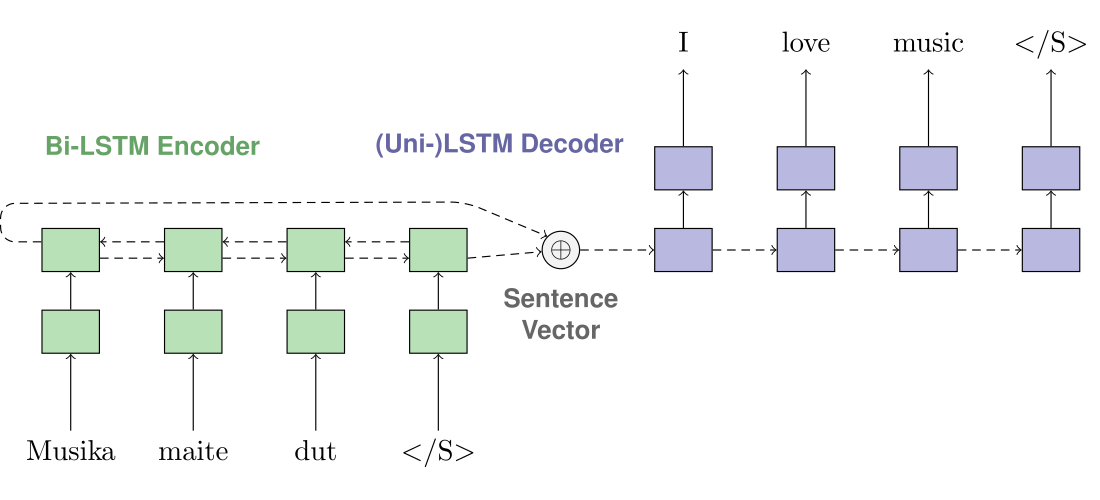

In [137]:
# %%tikz -l arrows,positioning -s 1100,500 -sc 1 -f svg --save mt_figures/encdec_rnn1.svg
#
#  \tikzset{state/.style={draw,rectangle,minimum height=1.5em,minimum width=2em,
#                          inner xsep=1em,inner ysep=0.5em},
#            addstate/.style={draw,circle,inner sep=0.1em,fill=gray!10},
#            emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.2em},
#            encembed/.style={fill=green!40!gray!40},
#            decembed/.style={fill=blue!40!gray!40},
#            encoder/.style={fill=green!40!gray!40},
#            decoder/.style={fill=blue!40!gray!40},
#            outer/.style={outer sep=0},
#            label/.style={align=center,font=\bfseries\small\sffamily,text height=0.5em}}
#
#      % input labels
#      \foreach \i [count=\step from 1] in {Musika,maite,dut,{$<$/S$>$}} {
#        \node[emptystate]    (EncI\step)  at (1.5*\step-1.5, 0)  {\i};
#      }
#
#      % embedding layers
#      \foreach \step in {1,...,4} {
#        \node[state,encembed] (EncE\step)  at (1.5*\step-1.5, 1.5) {};
#        \draw[->]             (EncI\step)  to (EncE\step);
#      }
#
#      % encoder LSTMs
#      \foreach \step in {1,...,4} {
#        \node[state,encoder] (EncLA\step)  at (1.5*\step-1.5, 2.5) {};
#        \draw[->]            (EncE\step)  to (EncLA\step);
#        \coordinate[below=0.1 of EncLA\step.east] (EncLA_be\step);
#        \coordinate[below=0.1 of EncLA\step.west] (EncLA_bw\step);
#        \coordinate[above=0.1 of EncLA\step.east] (EncLA_ae\step);
#        \coordinate[above=0.1 of EncLA\step.west] (EncLA_aw\step);
#      }
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \draw[densely dashed, ->]   (EncLA_be\step) to (EncLA_bw\next);
#        \draw[densely dashed, ->]   (EncLA_aw\next) to (EncLA_ae\step);
#      }
#
#      % encoded vectors
#      \node[addstate]        (EncVecA)  at (6.0, 2.5)   {$\oplus$};
#      \draw[densely dashed, ->]     (EncLA_be4) to (EncVecA);
#      \draw[densely dashed, ->, rounded corners=5pt]     (EncLA_aw1) -|([shift={(-5mm,3mm)}]EncLA1.north west) -- ([shift={(-10mm,4.2mm)}]EncVecA.north west) to (EncVecA.north west);
#
#
#      % decoder LSTMs
#      \foreach \step in {1,...,4} {
#        \node[state,decoder] (DecLA\step)  at (1.5*\step+6.0, 2.5) {};
#      }
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \draw[densely dashed, ->]   (DecLA\step.east) to (DecLA\next.west);
#      }
#      \draw[densely dashed, ->]     (EncVecA.east)    to (DecLA1.west);
#
#      % dense layer
#      \foreach \step in {1,...,4} {
#        \node[state,decoder] (DecD\step)  at (1.5*\step+6.0, 3.5) {};
#        \draw[->]            (DecLA\step) to (DecD\step);
#      }
#
#      % output labels
#      \foreach \i [count=\step from 1] in {I,love,music,{$<$/S$>$}} {
#        \node[emptystate]    (DecO\step)  at (1.5*\step+6.0, 5.0)  {\i};
#        \draw[->]            (DecD\step)  to (DecO\step);
#      }
#
#      % figure labels
#      \node[label,text=blue!40!black!60]   (DecLabel)   at (5.25, 3.75)  {(Uni-)LSTM Decoder};
#      \node[label,text=green!40!black!60]  (EncLabel)   at (1.0, 3.75)  {Bi-LSTM Encoder};
#      \node[label,text=black!60]          (asd)   at (6.0, 1.5)  {Sentence\\Vector};



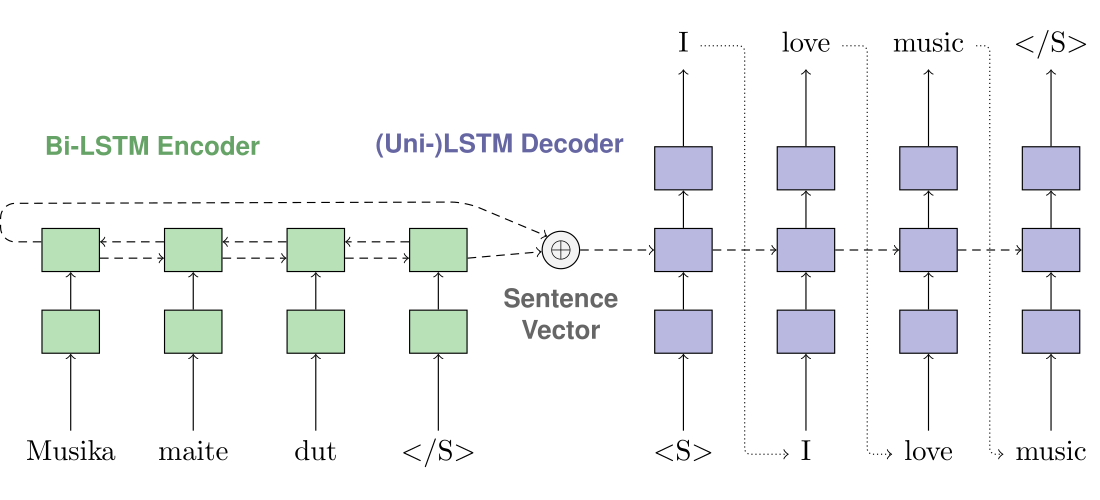

In [136]:
# %%tikz -l arrows,positioning -s 1100,500 -sc 1 -f svg --save mt_figures/encdec_rnn2.svg
#
#  \tikzset{state/.style={draw,rectangle,minimum height=1.5em,minimum width=2em,
#                          inner xsep=1em,inner ysep=0.5em},
#            addstate/.style={draw,circle,inner sep=0.1em,fill=gray!10},
#            emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.2em},
#            encembed/.style={fill=green!40!gray!40},
#            decembed/.style={fill=blue!40!gray!40},
#            encoder/.style={fill=green!40!gray!40},
#            decoder/.style={fill=blue!40!gray!40},
#            outer/.style={outer sep=0},
#            label/.style={align=center,font=\bfseries\small\sffamily,text height=0.5em}}
#
#      % input labels
#      \foreach \i [count=\step from 1] in {Musika,maite,dut,{$<$/S$>$}} {
#        \node[emptystate]    (EncI\step)  at (1.5*\step-1.5, 0)  {\i};
#      }
#      \foreach \i [count=\step from 1] in {{$<$S$>$},I,love,music} {
#        \node[emptystate]    (DecI\step)  at (1.5*\step+6.0, 0)  {\i};
#      }
#
#      % embedding layers
#      \foreach \step in {1,...,4} {
#        \node[state,encembed] (EncE\step)  at (1.5*\step-1.5, 1.5) {};
#        \node[state,decembed] (DecE\step)  at (1.5*\step+6.0, 1.5) {};
#        \draw[->]             (EncI\step)  to (EncE\step);
#        \draw[->]             (DecI\step)  to (DecE\step);
#      }
#
#      % encoder LSTMs
#      \foreach \step in {1,...,4} {
#        \node[state,encoder] (EncLA\step)  at (1.5*\step-1.5, 2.5) {};
#        \draw[->]            (EncE\step)  to (EncLA\step);
#        \coordinate[below=0.1 of EncLA\step.east] (EncLA_be\step);
#        \coordinate[below=0.1 of EncLA\step.west] (EncLA_bw\step);
#        \coordinate[above=0.1 of EncLA\step.east] (EncLA_ae\step);
#        \coordinate[above=0.1 of EncLA\step.west] (EncLA_aw\step);
#      }
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \draw[densely dashed, ->]   (EncLA_be\step) to (EncLA_bw\next);
#        \draw[densely dashed, ->]   (EncLA_aw\next) to (EncLA_ae\step);
#      }
#
#      % encoded vectors
#      \node[addstate]        (EncVecA)  at (6.0, 2.5)   {$\oplus$};
#      \draw[densely dashed, ->]     (EncLA_be4) to (EncVecA);
#      \draw[densely dashed, ->, rounded corners=5pt]     (EncLA_aw1) -|([shift={(-5mm,3mm)}]EncLA1.north west) -- ([shift={(-10mm,4.2mm)}]EncVecA.north west) to (EncVecA.north west);
#
#
#      % decoder LSTMs
#      \foreach \step in {1,...,4} {
#        \node[state,decoder] (DecLA\step)  at (1.5*\step+6.0, 2.5) {};
#        \draw[->]            (DecE\step)  to (DecLA\step);
#      }
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \draw[densely dashed, ->]   (DecLA\step.east) to (DecLA\next.west);
#      }
#      \draw[densely dashed, ->]     (EncVecA.east)    to (DecLA1.west);
#
#      % dense layer
#      \foreach \step in {1,...,4} {
#        \node[state,decoder] (DecD\step)  at (1.5*\step+6.0, 3.5) {};
#        \draw[->]            (DecLA\step) to (DecD\step);
#      }
#
#      % output labels
#      \foreach \i [count=\step from 1] in {I,love,music,{$<$/S$>$}} {
#        \node[emptystate]    (DecO\step)  at (1.5*\step+6.0, 5.0)  {\i};
#        \draw[->]            (DecD\step)  to (DecO\step);
#      }
#
#      % input-feeding connections
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \node[emptystate]   (Midway\step) at (1.5*\step+6.75, 3.75) {};
#        \draw[densely dotted, ->, rounded corners=2pt]    (DecO\step.east) -|(1.5*\step+6.75, 3.75) |-(DecI\next.west);
#      }
#
#      % figure labels
#      \node[label,text=blue!40!black!60]   (DecLabel)   at (5.25, 3.75)  {(Uni-)LSTM Decoder};
#      \node[label,text=green!40!black!60]  (EncLabel)   at (1.0, 3.75)  {Bi-LSTM Encoder};
#      \node[label,text=black!60]          (asd)   at (6.0, 1.5)  {Sentence\\Vector};



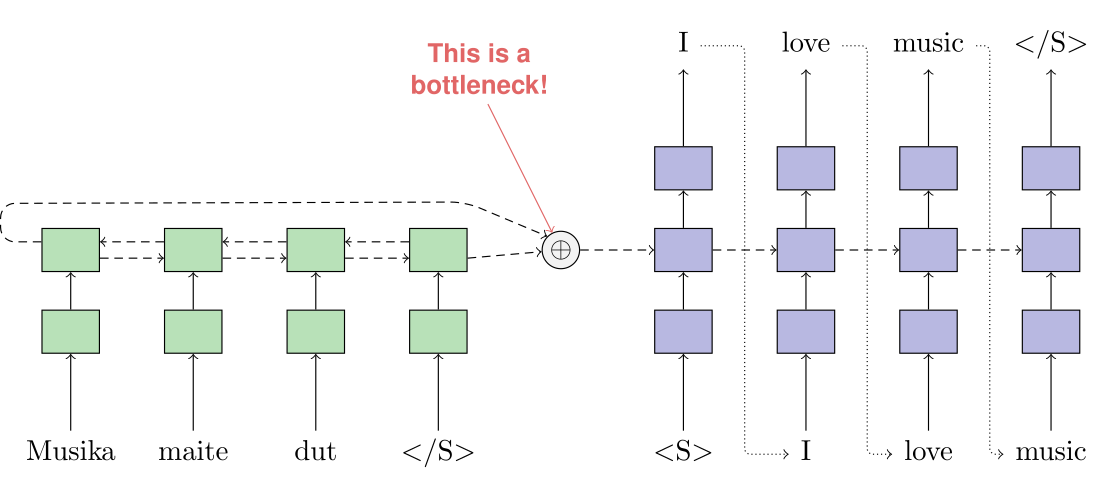

In [135]:
# %%tikz -l arrows,positioning -s 1100,500 -sc 1 -f svg --save mt_figures/encdec_rnn3.svg
#
#  \tikzset{state/.style={draw,rectangle,minimum height=1.5em,minimum width=2em,
#                          inner xsep=1em,inner ysep=0.5em},
#            addstate/.style={draw,circle,inner sep=0.1em,fill=gray!10},
#            emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.2em},
#            encembed/.style={fill=green!40!gray!40},
#            decembed/.style={fill=blue!40!gray!40},
#            encoder/.style={fill=green!40!gray!40},
#            decoder/.style={fill=blue!40!gray!40},
#            outer/.style={outer sep=0},
#            label/.style={align=center,font=\bfseries\small\sffamily,text height=0.5em}}
#
#      % input labels
#      \foreach \i [count=\step from 1] in {Musika,maite,dut,{$<$/S$>$}} {
#        \node[emptystate]    (EncI\step)  at (1.5*\step-1.5, 0)  {\i};
#      }
#      \foreach \i [count=\step from 1] in {{$<$S$>$},I,love,music} {
#        \node[emptystate]    (DecI\step)  at (1.5*\step+6.0, 0)  {\i};
#      }
#
#      % embedding layers
#      \foreach \step in {1,...,4} {
#        \node[state,encembed] (EncE\step)  at (1.5*\step-1.5, 1.5) {};
#        \node[state,decembed] (DecE\step)  at (1.5*\step+6.0, 1.5) {};
#        \draw[->]             (EncI\step)  to (EncE\step);
#        \draw[->]             (DecI\step)  to (DecE\step);
#      }
#
#      % encoder LSTMs
#      \foreach \step in {1,...,4} {
#        \node[state,encoder] (EncLA\step)  at (1.5*\step-1.5, 2.5) {};
#        \draw[->]            (EncE\step)  to (EncLA\step);
#        \coordinate[below=0.1 of EncLA\step.east] (EncLA_be\step);
#        \coordinate[below=0.1 of EncLA\step.west] (EncLA_bw\step);
#        \coordinate[above=0.1 of EncLA\step.east] (EncLA_ae\step);
#        \coordinate[above=0.1 of EncLA\step.west] (EncLA_aw\step);
#      }
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \draw[densely dashed, ->]   (EncLA_be\step) to (EncLA_bw\next);
#        \draw[densely dashed, ->]   (EncLA_aw\next) to (EncLA_ae\step);
#      }
#
#      % encoded vectors
#      \node[addstate]        (EncVecA)  at (6.0, 2.5)   {$\oplus$};
#      \draw[densely dashed, ->]     (EncLA_be4) to (EncVecA);
#      \draw[densely dashed, ->, rounded corners=5pt]     (EncLA_aw1) -|([shift={(-5mm,3mm)}]EncLA1.north west) -- ([shift={(-10mm,4.2mm)}]EncVecA.north west) to (EncVecA.north west);
#
#
#      % decoder LSTMs
#      \foreach \step in {1,...,4} {
#        \node[state,decoder] (DecLA\step)  at (1.5*\step+6.0, 2.5) {};
#        \draw[->]            (DecE\step)  to (DecLA\step);
#      }
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \draw[densely dashed, ->]   (DecLA\step.east) to (DecLA\next.west);
#      }
#      \draw[densely dashed, ->]     (EncVecA.east)    to (DecLA1.west);
#
#      % dense layer
#      \foreach \step in {1,...,4} {
#        \node[state,decoder] (DecD\step)  at (1.5*\step+6.0, 3.5) {};
#        \draw[->]            (DecLA\step) to (DecD\step);
#      }
#
#      % output labels
#      \foreach \i [count=\step from 1] in {I,love,music,{$<$/S$>$}} {
#        \node[emptystate]    (DecO\step)  at (1.5*\step+6.0, 5.0)  {\i};
#        \draw[->]            (DecD\step)  to (DecO\step);
#      }
#
#      % input-feeding connections
#      \foreach \step in {1,...,3} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \node[emptystate]   (Midway\step) at (1.5*\step+6.75, 3.75) {};
#        \draw[densely dotted, ->, rounded corners=2pt]    (DecO\step.east) -|(1.5*\step+6.75, 3.75) |-(DecI\next.west);
#      }
#
#      % figure labels
#      \node[label,text=red!80!black!60]          (asd)   at (5.0, 4.5)  {This is a\\bottleneck!};
#      \draw[->,color=red!80!black!60] (asd) to (EncVecA);


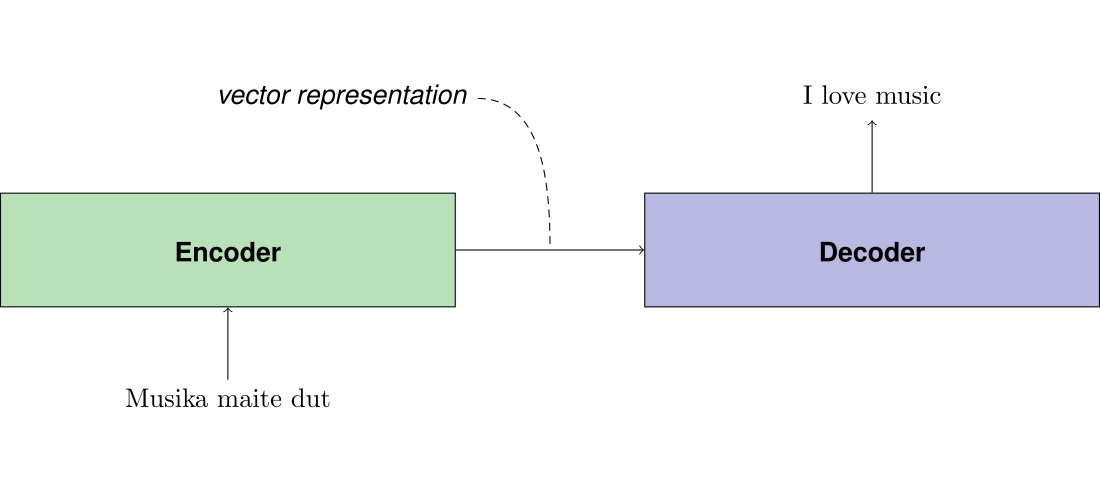

In [107]:
# %%tikz -l arrows,positioning -s 1100,500 -sc 1 -f svg --save mt_figures/encdec.svg
#
#   \tikzset{state/.style={draw,rectangle,minimum height=2em,minimum width=3.5em,
#                          inner xsep=1em,inner ysep=0.5em,text height=1em,text depth=0.15em},
#            emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.2em},
#            encoder/.style={minimum width=6cm,minimum height=1.5cm,fill=green!40!gray!40,font=\bfseries\sffamily},
#            decoder/.style={minimum width=6cm,minimum height=1.5cm,fill=blue!40!gray!40,font=\bfseries\sffamily},
#            outer/.style={outer sep=0},
#            label/.style={align=center,font=\itshape\small}}
#
#      \node[emptystate]      (I1)  at (2.5,  0)         {{Musika maite dut}};
#
#      \node[state,encoder]           (ENC)  at (2.5,  2)         {{Encoder}};
#      \draw [->]  (I1) to (ENC.south);
#
#      \node[emptystate]      (O1) at (11,  4)         {I love music};
#
#      \node[state,decoder]           (DEC)  at (11, 2)         {{Decoder}};
#      \draw [->]  (DEC.north) to (O1);
#
#      \draw [->]  (ENC) to (DEC);
#
#      \node[emptystate]    (V) at (4.0, 4.0)     {\sffamily\textit{vector representation}};
#
#      \node[emptystate]    (ED) at (6.75,   1.75)     {};
#      \draw [densely dashed]  (V.east) to[out=0,in=90] (ED.north);


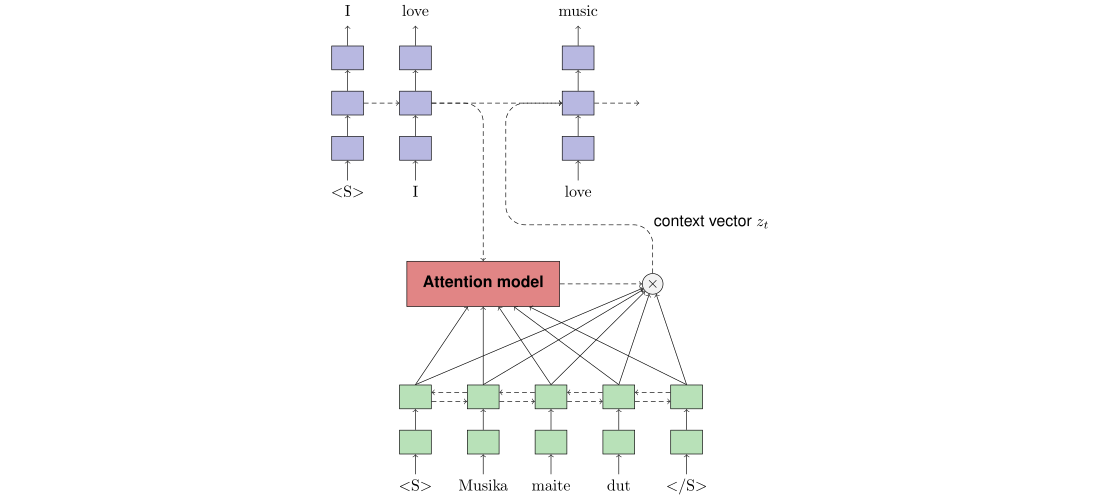

In [170]:
# %%tikz -l arrows,positioning -s 1100,500 -sc 1 -f svg --save mt_figures/encdec_att.svg
#
# \tikzset{state/.style={draw,rectangle,minimum height=1.5em,minimum width=2em,
#                          inner xsep=1em,inner ysep=0.5em},
#            addstate/.style={draw,circle,inner sep=0.1em,fill=gray!10},
#            emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.2em},
#            encembed/.style={fill=green!40!gray!40},
#            decembed/.style={fill=blue!40!gray!40},
#            encoder/.style={fill=green!40!gray!40},
#            decoder/.style={fill=blue!40!gray!40},
#            outer/.style={outer sep=0},
#            attention/.style={minimum width=3cm,minimum height=1cm,text height=0.6em,text depth=0.2em,align=center,font=\bfseries\sffamily,fill=red!60!gray!60}}
#
#      % input labels
#      \foreach \i [count=\step from 1] in {{$<$S$>$},Musika,maite,dut,{$<$/S$>$}} {
#        \node[emptystate]    (EncI\step)  at (1.5*\step-1.5, 1.0)  {\i};
#      }
#
#      % embedding layer
#      \foreach \step in {1,...,5} {
#        \node[state,encembed] (EncE\step)  at (1.5*\step-1.5, 2.0) {};
#        \draw[->]             (EncI\step)  to (EncE\step);
#      }
#
#      % encoder LSTMs
#      \foreach \step in {1,...,5} {
#        \node[state,encoder] (EncLA\step)  at (1.5*\step-1.5, 3.0) {};
#        \draw[->]            (EncE\step)  to (EncLA\step);
#        \coordinate[below=0.1 of EncLA\step.east] (EncLA_be\step);
#        \coordinate[below=0.1 of EncLA\step.west] (EncLA_bw\step);
#        \coordinate[above=0.1 of EncLA\step.east] (EncLA_ae\step);
#        \coordinate[above=0.1 of EncLA\step.west] (EncLA_aw\step);
#      }
#      \foreach \step in {1,...,4} {
#        \pgfmathtruncatemacro{\next}{add(\step,1)}
#        \draw[densely dashed, ->]   (EncLA_be\step) to (EncLA_bw\next);
#        \draw[densely dashed, ->]   (EncLA_aw\next) to (EncLA_ae\step);
#      }
#
#      % attentional model
#      \node[state,attention]   (Att)  at (1.5,  5.5)  {Attention model};
#      \node[addstate]          (Mult) at (5.25, 5.5)  {$\times$};
#      \foreach \step in {1,...,5} {
#        \draw[->]      (EncLA\step.north) to (Att);
#        \draw[->]      (EncLA\step.north) to (Mult);
#      }
#      \draw[densely dashed, ->] (Att) to (Mult);
#
#
#      % decoder
#      \node[emptystate]     (DecO1)      at (0.0, 11.5)    {love};
#      \node[emptystate]     (DecO2)      at (3.6, 11.5)    {music};
#      \foreach \i [count=\step from 1] in {I,love} {
#        \node[emptystate]     (DecI\step)  at (3.6*\step-3.6,  7.5)   {\i};
#        \node[state,decembed] (DecE\step)  at (3.6*\step-3.6,  8.5)   {};
#        \node[state,decoder]  (DecL\step)  at (3.6*\step-3.6,  9.5)   {};
#        \node[state,decoder]  (DecD\step)  at (3.6*\step-3.6, 10.5)   {};
#      }
#
#      \node[emptystate]        (DecI0)      at (-1.5, 7.5) {$<$S$>$};
#      \node[state,decembed]    (DecE0)      at (-1.5, 8.5) {};
#      \node[state,decoder]     (DecL0)      at (-1.5,  9.5) {};
#      \node[state,decoder]     (DecD0)      at (-1.5, 10.5) {};
#      \node[emptystate]        (DecO0)      at (-1.5, 11.5) {I};
#
#      \foreach \step in {0,...,2} {
#        \draw[->]             (DecI\step)  to (DecE\step);
#        \draw[->]             (DecE\step)  to (DecL\step);
#        \draw[->]             (DecL\step)  to (DecD\step);
#        \draw[->]             (DecD\step)  to (DecO\step);
#      }
#
#      \node[emptystate]     (DecLx)      at (5.1,  9.5) {};
#      \draw[densely dashed, ->]  (DecL0) to (DecL1);
#      \draw[densely dashed, ->]  (DecL1) to (DecL2);
#      \draw[densely dashed, ->]  (DecL2) to (DecLx);
#      \draw[densely dashed, ->, rounded corners=12pt]  (DecL1) -| (Att);
#      \draw[densely dashed, ->, rounded corners=12pt]  (Mult.north) |-([shift={(5mm,8mm)}]Att.north) |- (DecL2.west);
#
#      \node[emptystate]     at (0.8, 7)  {};
#      \node[emptystate]     at (6.55, 6.85)  {\sffamily context vector $z_t$};


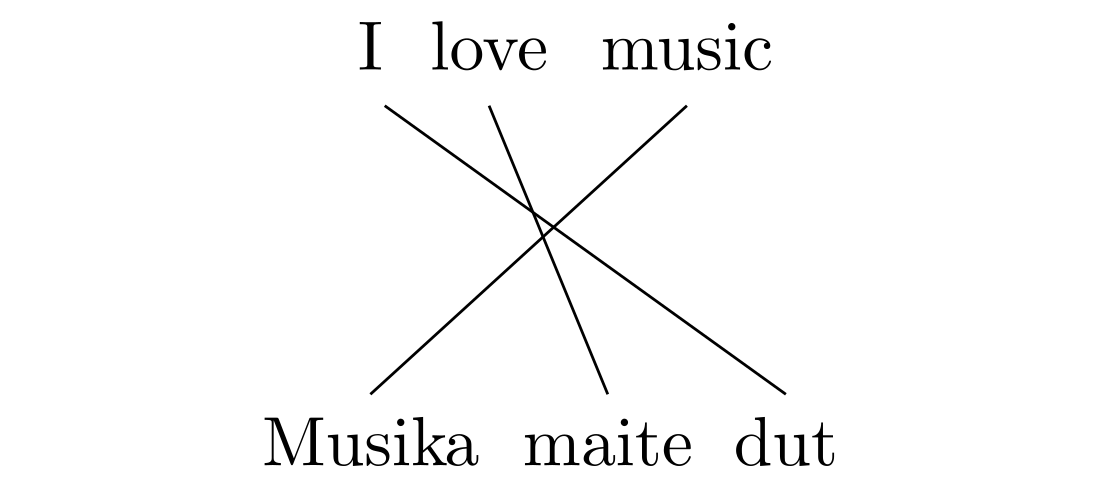

In [193]:
# %%tikz -l arrows,positioning -s 1100,500 -sc 1 -f svg --save mt_figures/align.svg
#
#   \tikzset{state/.style={draw,rectangle,minimum height=2em,minimum width=3.5em,
#                          inner xsep=1em,inner ysep=0.5em,text height=1em,text depth=0.15em},
#            emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.1em},
#            label/.style={align=center,font=\itshape\small}}
#
#      \node[emptystate]      (I1)  at (0,  0)         {{Musika}};
#      \node[emptystate]      (I2)  at (1.2,  0)         {{maite}};
#      \node[emptystate]      (I3)  at (2.1,  0)         {{dut}};
#
#      \node[emptystate]      (O1)  at (0,  2)         {{I}};
#      \node[emptystate]      (O2)  at (0.6,  2)         {{love}};
#      \node[emptystate]      (O3)  at (1.6,  2)         {{music}};
#
#
#      \draw [-]  (I1.north) to (O3.south);
#      \draw [-]  (I3.north) to (O1.285);
#      \draw [-]  (I2.north) to (O2.south);


